# ATP6V0C
[early-onset epilepsy-3 with or without developmental delay (EPEO3)](https://omim.org/entry/620465) is caused by heterozygous mutation in the ATP6V0C gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


### ATP6V0C
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ATP6V0C.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'ATP6V0C'
mane_tx_id = 'NM_001694.4'
mane_protein_id = 'NP_001685.1' # V-type proton ATPase 16 kDa proteolipid subunit c
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.24') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)

qc_results.summarize()

Individuals Processed: 100%|██████████| 31/31 [00:00<00:00, 90.46 individuals/s] 
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
21,Global developmental delay
18,Bilateral tonic-clonic seizure
15,EEG abnormality
12,Febrile seizure (within the age range of 3 months to 6 years)
12,Delayed speech and language development
11,Motor delay
10,Autistic behavior
8,Myoclonic seizure
7,Atonic seizure
6,Hypotonia


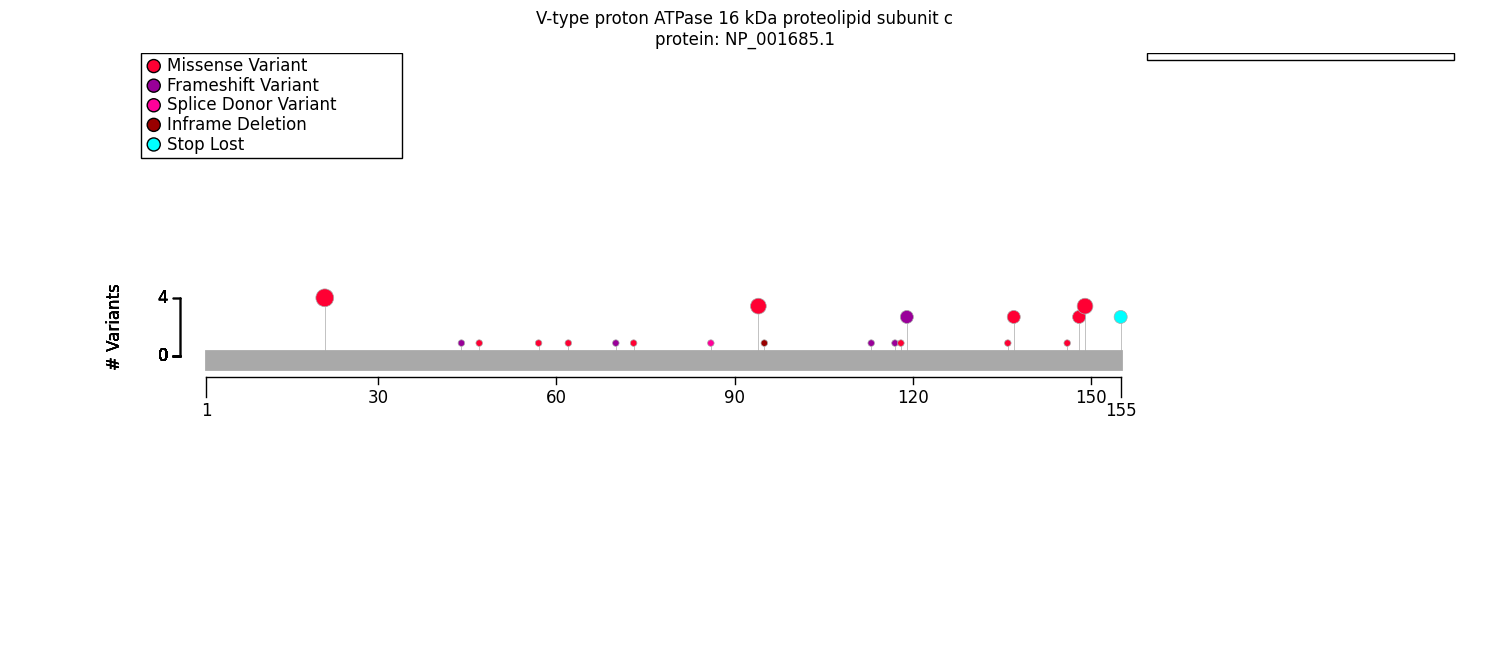

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

ATP6V0C_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
ATP6V0C_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.model.genome import Region
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import protein_region
from gpsea.view import MtcStatsViewer


n_term = protein_region(region=Region(0,100), tx_id=mane_tx_id)
n_term_clf = monoallelic_classifier(a_predicate=n_term, 
                                         b_predicate=~ n_term, 
                                         a_label="1-100", 
                                         b_label="100+")
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=n_term_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(nterm_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,4
"Skipping ""general"" level terms",57
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),132


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group,1-100,100+,Corrected p values,p values
"Intellectual disability, mild [HP:0001256]",0/11 (0%),4/10 (40%),0.998217,0.035088
High palate [HP:0000218],2/7 (29%),0/11 (0%),0.998217,0.137255
Febrile seizure (within the age range of 3 months to 6 years) [HP:0002373],8/15 (53%),4/16 (25%),0.998217,0.148884
Infantile spasms [HP:0012469],2/9 (22%),0/13 (0%),0.998217,0.155844
Myoclonic seizure [HP:0032794],6/15 (40%),2/15 (13%),0.998217,0.214759
...,...,...,...,...
Intellectual disability [HP:0001249],6/6 (100%),11/11 (100%),1.000000,1.000000
Abnormality of central nervous system electrophysiology [HP:0030178],6/6 (100%),9/9 (100%),1.000000,1.000000
Bilateral tonic-clonic seizure [HP:0002069],7/7 (100%),12/12 (100%),1.000000,1.000000
Motor seizure [HP:0020219],7/7 (100%),7/7 (100%),1.000000,1.000000


In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf= monoallelic_classifier(a_predicate=missense,
                                           b_predicate=~missense,
                                           a_label="missense",
                                           b_label="other"
                                           )
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense,other,Corrected p values,p values
Developmental regression [HP:0002376],0/11 (0%),3/4 (75%),0.703297,0.008791
Focal impaired awareness seizure [HP:0002384],0/20 (0%),2/9 (22%),1.000000,0.088670
Single transverse palmar crease [HP:0000954],0/14 (0%),1/3 (33%),1.000000,0.176471
Mitral regurgitation [HP:0001653],0/14 (0%),1/3 (33%),1.000000,0.176471
Mitral stenosis [HP:0001718],0/14 (0%),1/3 (33%),1.000000,0.176471
...,...,...,...,...
Scoliosis [HP:0002650],3/14 (21%),0/3 (0%),1.000000,1.000000
"Intellectual disability, mild [HP:0001256]",3/16 (19%),1/5 (20%),1.000000,1.000000
Generalized non-motor (absence) seizure [HP:0002121],4/21 (19%),1/9 (11%),1.000000,1.000000
Autistic behavior [HP:0000729],8/14 (57%),2/3 (67%),1.000000,1.000000


In [10]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
High palate [HP:0000218],2/6 (33%),0/12 (0%),1.0,0.098039
EEG abnormality [HP:0002353],3/7 (43%),12/14 (86%),1.0,0.119582
Developmental regression [HP:0002376],2/4 (50%),1/11 (9%),1.0,0.153846
Myoclonic seizure [HP:0032794],1/11 (9%),7/19 (37%),1.0,0.198698
Hippocampal sclerosis [HP:0033715],2/8 (25%),1/17 (6%),1.0,0.231304
...,...,...,...,...
Abnormal communication [HP:0034434],5/5 (100%),11/11 (100%),1.0,1.000000
Motor seizure [HP:0020219],5/5 (100%),9/9 (100%),1.0,1.000000
Bilateral tonic-clonic seizure [HP:0002069],7/7 (100%),12/12 (100%),1.0,1.000000
Neurodevelopmental delay [HP:0012758],7/7 (100%),14/14 (100%),1.0,1.000000


In [11]:
from gpsea.analysis.temporal.endpoint import disease_onset
from gpsea.analysis.temporal.stats import LogRankTest
from gpsea.analysis.temporal import SurvivalAnalysis



EPEO3 = "OMIM:620465" # Epilepsy, early-onset, 3, with or without developmental delay
endpoint = disease_onset(disease_id=EPEO3)
survival_statistic = LogRankTest()
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
missense_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=endpoint,
)
print(f"survival analysis p={missense_onset_result.pval:.5f}")

survival analysis p=0.19317


Text(1000, 0.6, '$p=0.19317$')

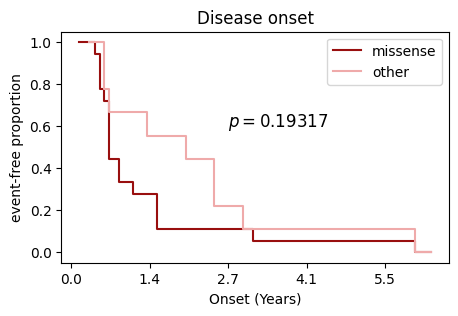

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from gpsea.model import Age

onset_fig, ax = plt.subplots(figsize=(5, 3))
missense_onset_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / Age.DAYS_IN_YEAR:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Disease onset")
s = f"p={missense_onset_result.pval:.5f}"
ax.text(x=1000, y=0.6, s=f"${s}$", fontsize=12)

# Summary

In [13]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport


m_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_onset_result
    ),
)

f_results =  (
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ), 
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ), 
)

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
   mono_results=m_results,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [15]:
summarizer.process_latex(report=report, protein_fig=ATP6V0C_fig, stats_fig=onset_fig)

Figure saved to ../../supplement/img/ATP6V0C_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/ATP6V0C_stats-draft.pdf
Output to ../../supplement/tex/ATP6V0C_summary_draft.tex
